# Generate animation of ice from HYCOM to support Sea Ice for Walrus Outlook

## Purpose
The SIWO community is supported by multiple groups including [ARCUS](https://www.arcus.org/siwo), the [National Weather Service Fairbanks Decision Support office](https://www.weather.gov/afg/SIWO_overview), and an active [Facebook community page](https://www.facebook.com/seaiceforwalrus).

Axiom Data Science was asked by the Alaska Ocean Observing System to explore putting together some supporting imagery that could be regularly produced and sent out each week via email or the web. The requirements:

- show ice movement in and around Alaska waters
- produce a product small enough for low-bandwidth areas of Alaska

## Inputs
We used prediction results from the HYbrid Coordinate Ocean Model (HYCOM). HYCOM produces many different outputs, but their [Global Ocean Forecasting System (GOFS) 3.1 Analysis](https://www.hycom.org/) produces fields for ice area fraction and sea ice velocity, there are snapshots of the model results every 3 hours, and forecasts generally extend a week into the future. They also offer THREDDS end-point, and if you spatially subset the data the aggregated file downloads aren’t too bad (~360 Mb).

## Outputs
Aiming for a gif animation that shows ice for the currently available forecast period (nominally, at least one week).

In [1]:
from typing import Tuple
from datetime import datetime
from pandas import Timestamp, Timedelta
import numpy as np
import xarray as xr
import cartopy
import cmocean
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.figure import Figure
import io
from PIL import Image
from tqdm.notebook import tqdm, trange
import imageio

## Let's get a file from the HYCOM THREDDS Server
NetCDF subset:  
https://ncss.hycom.org/thredds/catalog/GLBy0.08/expt_93.0/FMRC/ice/runs/catalog.html

But each run gets it's own catalog entry:  
https://ncss.hycom.org/thredds/catalog/GLBy0.08/expt_93.0/FMRC/ice/runs/catalog.html?dataset=GLBy0.08/expt_93.0/FMRC/ice/runs/GLBy0.08_930_FMRC_ice_RUN_2022-03-17T12:00:00Z

Then:  
https://ncss.hycom.org/thredds/ncss/grid/GLBy0.08/expt_93.0/FMRC/ice/runs/GLBy0.08_930_FMRC_ice_RUN_2022-03-17T12:00:00Z/dataset.html

And this is the final query:  
https://ncss.hycom.org/thredds/ncss/GLBy0.08/expt_93.0/FMRC/ice/runs/GLBy0.08_930_FMRC_ice_RUN_2022-03-17T12:00:00Z?var=sic&var=siu&var=siv&north=80&west=150&east=250&south=45&disableProjSubset=on&horizStride=1&time_start=2022-03-17T12%3A00%3A00Z&time_end=2022-03-25T00%3A00%3A00Z&timeStride=1&accept=netcdf4

In [2]:
yes = Timestamp.today() - Timedelta('1 day')
loc = yes.strftime('https://tds.hycom.org/thredds/dodsC/GLBy0.08/expt_93.0/FMRC/ice/runs/GLBy0.08_930_FMRC_ice_RUN_%Y-%m-%dT12:00:00Z')
hycom = xr.open_dataset(loc, drop_variables='tau')
hycom = hycom.sel(lat=slice(55,72), lon=slice(175,215))

In [3]:
%%time
hycom = hycom[['sic', 'siv', 'siu']].load()

CPU times: user 2.48 s, sys: 1.21 s, total: 3.7 s
Wall time: 46 s


In [4]:
def make_basemap(
        extent: Tuple = None,
        lat_stride: int = 10,
        lon_stride: int = 30
):
    """Produces the figure's geospatially aware basemap."""
    
    figure_background = '#000000'
    plate_crs = cartopy.crs.PlateCarree()
    merc_crs = cartopy.crs.Mercator(central_longitude=-150)

    fig = plt.figure(dpi=144, figsize=(14, 14))
    fig.patch.set_facecolor(figure_background)

    # setting the anchor means we will lock in the upper left side after the aspect changes
    ax = fig.add_axes([0, 0, 1, 1], projection = merc_crs, frameon=False)
    ax.set_extent(extent, crs=plate_crs)
    ax.spines['geo'].set_edgecolor('white')
    ax.spines['geo'].set_visible(False)
    
    # Contextual Map Elements
    land_color = '#333333'
    coast_color = '#333333'
    ocean_color = '#040613'
    land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                                   edgecolor=coast_color,
                                                   facecolor=land_color,
                                                   zorder=10)
    ax.add_feature(land_10m)
    rivers = cartopy.feature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m',
                                                 edgecolor=ocean_color,
                                                 facecolor='none',
                                                 zorder=11)
    ax.add_feature(rivers, alpha=0.2)
    lakes = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '10m',
                                                edgecolor='#000000',
                                                facecolor=ocean_color,
                                                zorder=11)
    ax.add_feature(lakes, alpha=0.2)
    
    return fig, ax

def make_map(
    hycom: xr.Dataset,
    time: datetime,
    extent: Tuple = (175, 215, 55, 72),
    lat_stride: int = 5,
    lon_stride: int = 10,
    padding: float = 0.01,
) -> Figure:
    """Let's make this map."""
    
    fig, ax = make_basemap(extent=extent, lat_stride=lat_stride, lon_stride=lon_stride)
    plate_crs = cartopy.crs.PlateCarree()
    ax.pcolormesh(hycom['lon'], hycom['lat'], hycom['sic'], transform = plate_crs,
                  cmap=cmocean.cm.ice, vmin=0, vmax=1, zorder=2)
    
    def xcoords(lat, lon):
        """Do the things quiver needs for latitudes and longitudes."""
        xlat = np.tile(lat, len(lon))
        xlat = np.reshape(xlat, (len(lon), len(lat)))
        xlat = xlat.T
        xlon = np.tile(lon, len(lat))
        xlon = np.reshape(xlon, (len(lat), len(lon)))
        return xlat, xlon
    
    hycom_xlat, hycom_xlon = xcoords(hycom['lat'].values, hycom['lon'].values)
    icev_xstride=20
    icev_ystride=20
    iceq = ax.quiver(hycom_xlon[::icev_ystride, ::icev_xstride], hycom_xlat[::icev_ystride, ::icev_xstride],
                    hycom['siu'][::icev_ystride,::icev_xstride].values, hycom['siv'][::icev_ystride,::icev_xstride].values,
                    transform=plate_crs, facecolor='white', alpha=1.0, scale=20, pivot='tip',
                    headlength=3, headaxislength=2.8, width=0.005, linewidth=0.5, zorder=5, edgecolor='black')
    levels = [0.15]
    ax.contour(hycom['lon'].values, hycom['lat'].values, hycom['sic'].values, levels, colors='#ffffff',
               linewidths=0.5, transform = plate_crs, zorder=3)
    primary_label = Timestamp(time).strftime('%b %d, %H:%M')
    ax_bottom = ax.get_position().y0
    ax_left   = ax.get_position().x0
    y_padding = padding
    x_padding = padding
    ax.text(
        ax_left + x_padding,
        ax_bottom + y_padding,
        primary_label,
        color='white',
        verticalalignment = 'bottom',
        horizontalalignment = 'left',
        fontsize=45,
        transform=ax.transAxes,
        zorder=20
    )
    ax.text(
        ax_left + x_padding,
        ax_bottom + y_padding + 0.06,
        'Data from HYCOM \nArrows = Ice Velocity',
        color='white',
        verticalalignment = 'bottom',
        horizontalalignment = 'left',
        fontsize=20,
        transform=ax.transAxes,
        zorder=20
    )
    
    # save and pass back
    buf = io.BytesIO()
    figure_background = '#000000'
    fig.savefig(buf, bbox_inches='tight', format='PNG', facecolor=figure_background)
    plt.close(fig)
    
    return Image.open(buf)

/opt/conda/envs/py37/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/opt/conda/envs/py37/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_rivers_lake_centerlines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/opt/conda/envs/py37/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


CPU times: user 23.4 s, sys: 1.65 s, total: 25 s
Wall time: 29 s


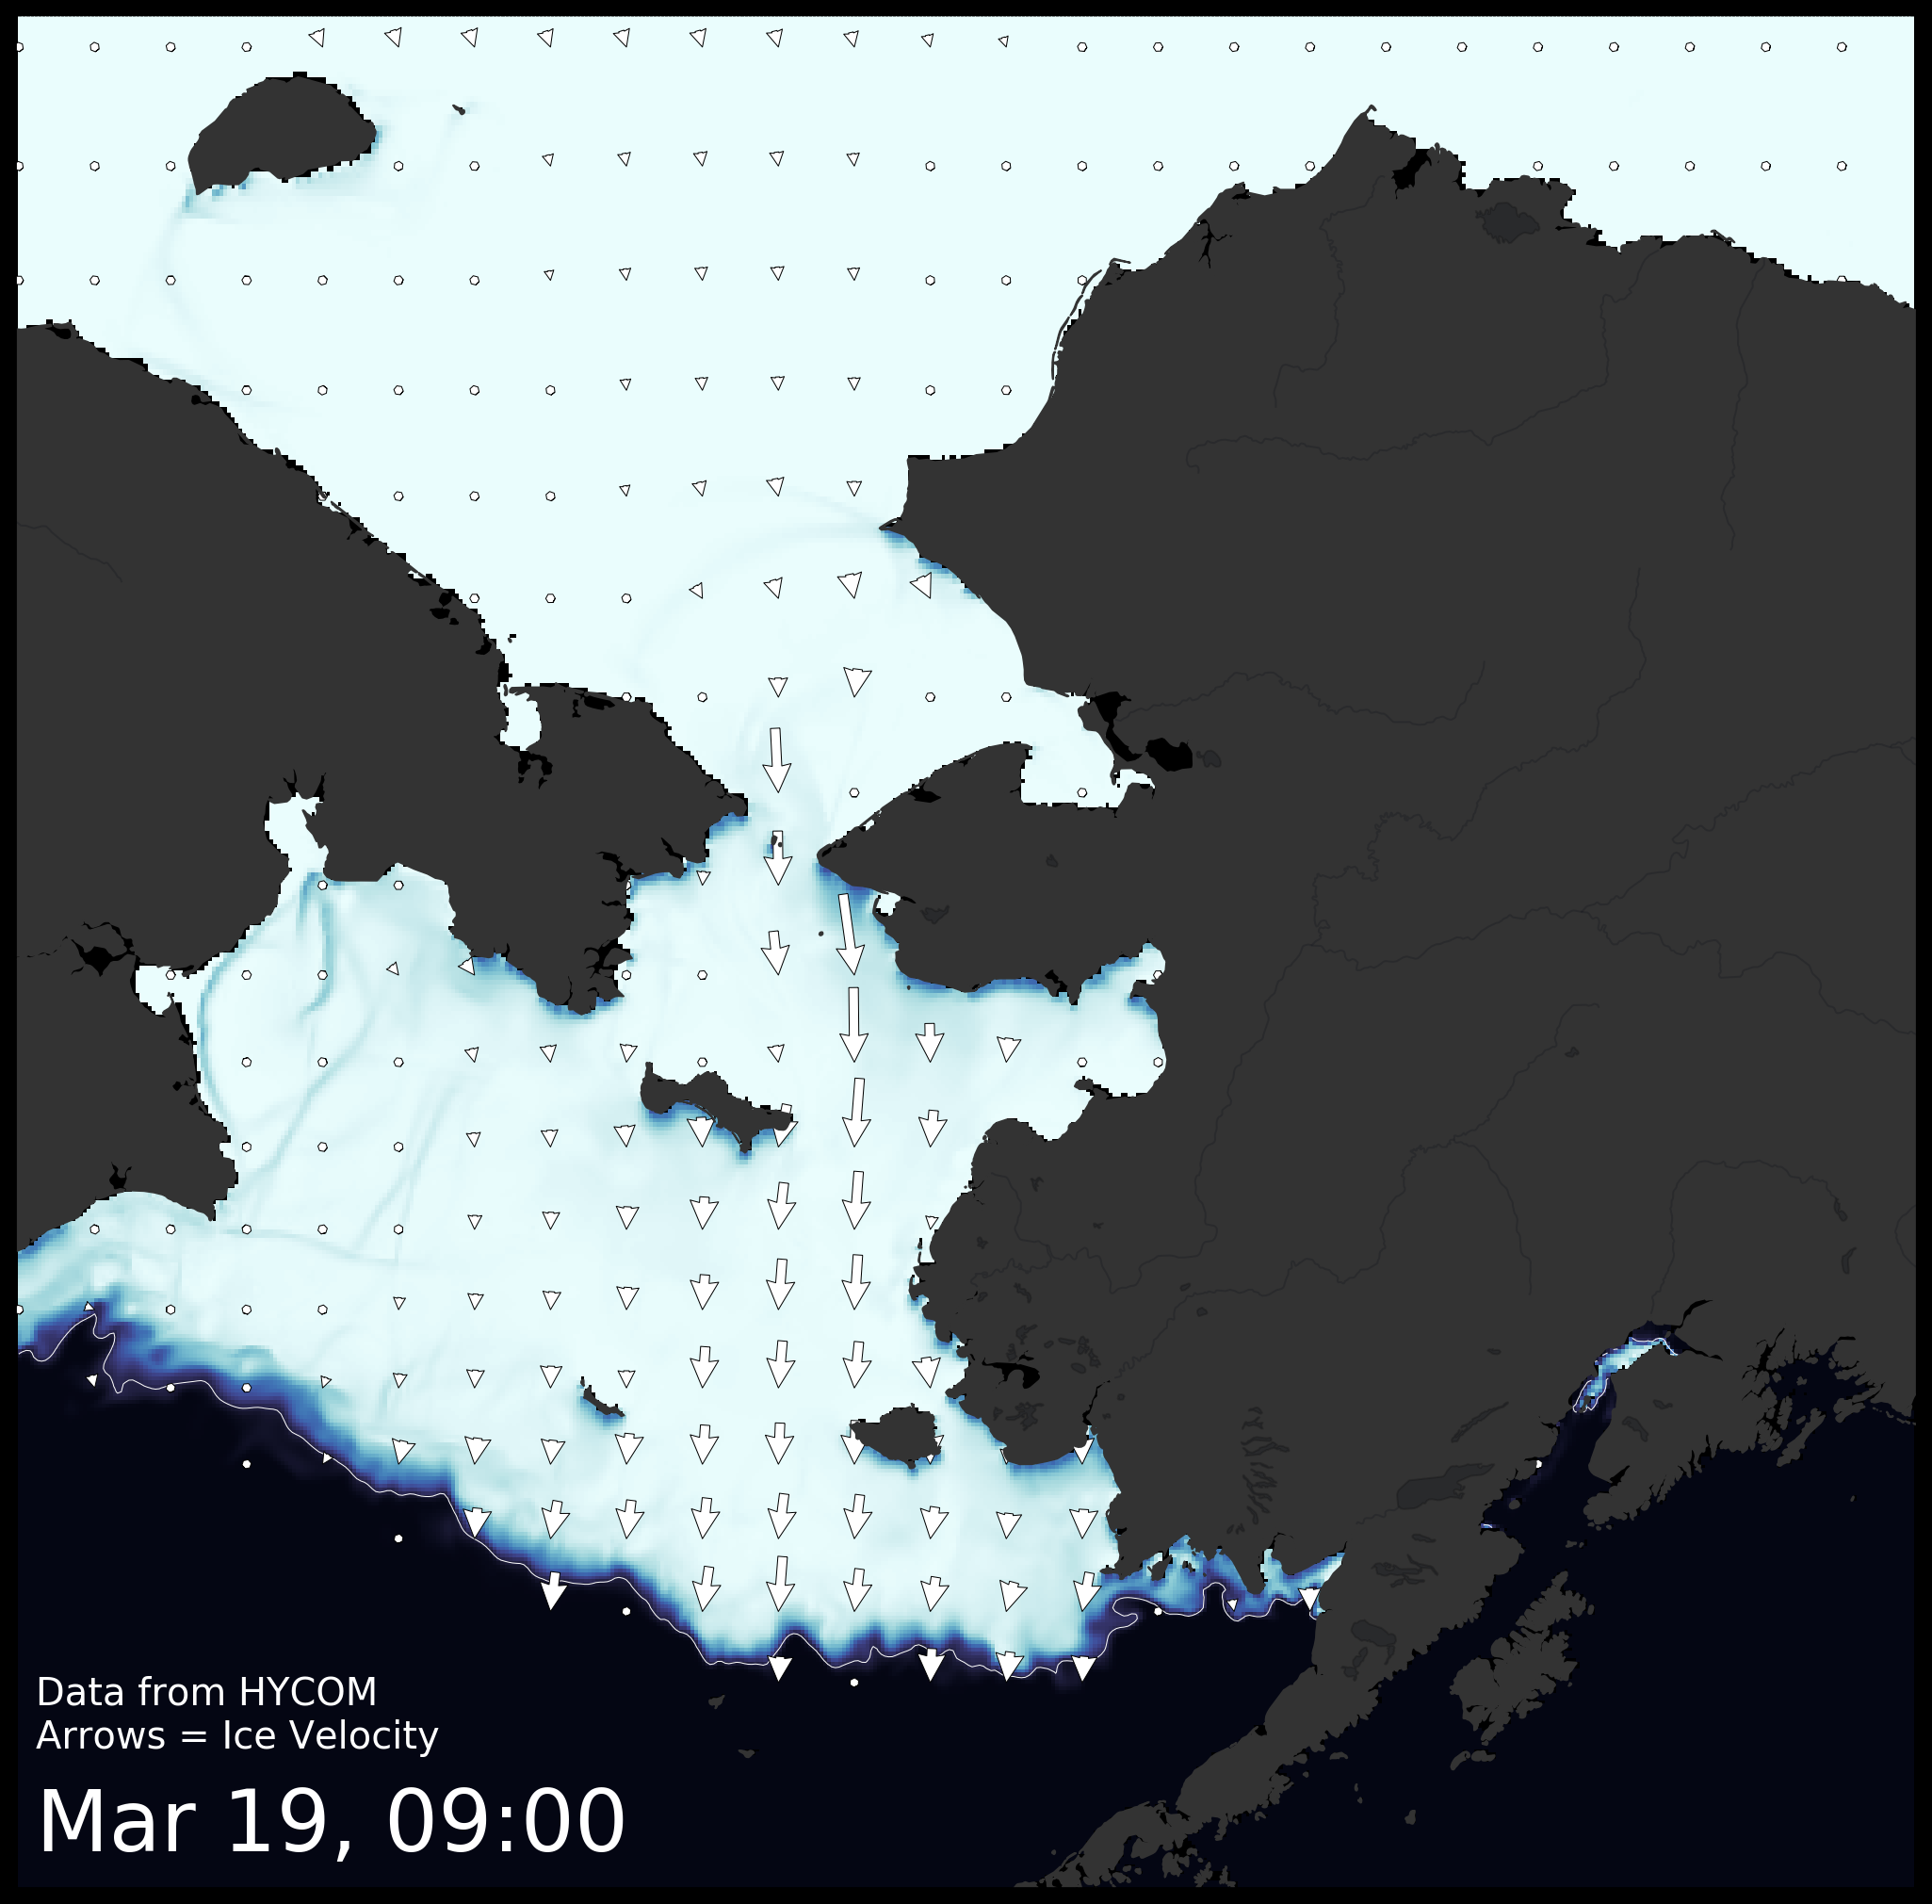

In [5]:
%%time
times = hycom['sic']['time'].values
make_map(hycom.sel(time=times[15]), times[15])

## Loop through all the available times

In [6]:
times = hycom['sic']['time'].values
results = []
for time in tqdm(times):
    result = make_map(hycom.sel(time=time), time)
    results.append(result)

  0%|          | 0/61 [00:00<?, ?it/s]

## Compress the frames, and then make a gif

In [7]:
def resize_image(input_image, width=1280):
    oldwidth = input_image.size[0]
    height = int(input_image.size[1] * (width/oldwidth))
    output_image = input_image.resize((width, height), Image.ANTIALIAS)
    return output_image

In [8]:
outdir = yes.strftime('%Y%m%d')
quality=50
width=640
downsized = [resize_image(result, width=width) for result in results]
out_name = f'../gifs/iceforecast-{outdir}-pil-{width}-q{quality}.gif'
downsized[0].save(fp=out_name, format='GIF', append_images=downsized[1:],
                  quality=quality, save_all=True,
                  duration=250, loop=0, optimize=True)